# Data Analysis for FD003

In [32]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.nonparametric.smoothers_lowess import lowess
import pymannkendall as mk

## Data Preprocessing

In [33]:
train_data_df = pd.read_csv('../../TED/CMAPSSData/train_FD003.txt', sep=' ', header = None)
test_data_df = pd.read_csv('../../TED/CMAPSSData/test_FD003.txt', sep=' ', header = None)
test_labels_at_break_df = pd.read_csv('../../TED/CMAPSSData/RUL_FD003.txt', sep=' ', header = None)

train_data_df.drop(train_data_df.columns[[-1, -2]], axis=1, inplace=True)
test_data_df.drop(test_data_df.columns[[-1, -2]], axis=1, inplace=True)
test_labels_at_break_df.drop(test_labels_at_break_df.columns[[-1]], axis=1, inplace=True)

### Extracting labels and organising the data

In [34]:
column_names = ['ID', 'Cycle', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure1', 'SensorMeasure2', 'SensorMeasure3', 'SensorMeasure4', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure7', 'SensorMeasure8', 'SensorMeasure9', 'SensorMeasure10', 'SensorMeasure11', 'SensorMeasure12', 'SensorMeasure13', 'SensorMeasure14', 'SensorMeasure15', 'SensorMeasure16', 'SensorMeasure17', 'SensorMeasure18', 'SensorMeasure19', 'SensorMeasure20', 'SensorMeasure21']

train_data_df.columns = column_names
max_cycles_train_df = train_data_df.groupby(['ID'], sort=False)['Cycle'].max().reset_index().rename(columns={'Cycle':'MaxCycleID'})

train_data_df = pd.merge(train_data_df, max_cycles_train_df, how='inner', on='ID')
train_data_df['RUL'] = train_data_df['MaxCycleID'] - train_data_df['Cycle']
train_data_df.drop(columns=['MaxCycleID'], inplace=True)

test_data_df.columns = column_names
max_cycles_test_df = test_data_df.groupby(['ID'], sort=False)['Cycle'].max().reset_index().rename(columns={'Cycle':'MaxCycleID'})

test_labels_at_break_df.columns = ['RUL']
test_labels_at_break_df['ID'] = max_cycles_test_df['ID']
test_labels_at_break_df['RUL'] = test_labels_at_break_df['RUL'] + max_cycles_test_df['MaxCycleID']

test_data_df = pd.merge(test_data_df, test_labels_at_break_df, how='inner', on='ID')
test_data_df['RUL'] = test_data_df['RUL'] - test_data_df['Cycle']

In [35]:
train_labels_df = train_data_df['RUL']
test_labels_df = test_data_df['RUL']
train_labels_at_break_df = train_data_df.groupby('ID').last().reset_index()['RUL']

### Divide by engine

In [36]:
train_groupby = train_data_df.groupby(['ID'], sort=False)
test_groupby = test_data_df.groupby(['ID'], sort=False)

### Graphs: Data before analysed

In [37]:
sensor_names = []
for i in range(3):
    sensor_names.append('OpSet' + str(i+1))
for i in range(21):
    sensor_names.append('SensorMeasure' + str(i+1))

In [38]:
def divide_by_engine(df_groupby):

    groupby_arr = []
    for i in range(len(df_groupby)):
        groupby_arr.append(df_groupby.get_group(i+1))

    for i in range(len(df_groupby)):
        groupby_arr[i] = groupby_arr[i].to_numpy()

    return groupby_arr

In [39]:
def plot_by_engine(train_gb, rows, names, filename):

    train_groupby_arr = divide_by_engine(train_gb)

    fig, axs = plt.subplots(rows, 4)
    flat_axs = axs.flatten()
    for sensor in range(len(names)):
        flat_axs[sensor].set_title(names[sensor])
        for engine in range(len(train_groupby_arr)):
            flat_axs[sensor].plot(train_groupby_arr[engine][:, 1], train_groupby_arr[engine][:, sensor + 2])

    plt.setp(axs[-1, :], xlabel='Cycles')
    plt.setp(axs[:, 0], ylabel='Sensor readings')
    fig.set_size_inches(20, 30) 
    plt.savefig(filename)
    plt.show()

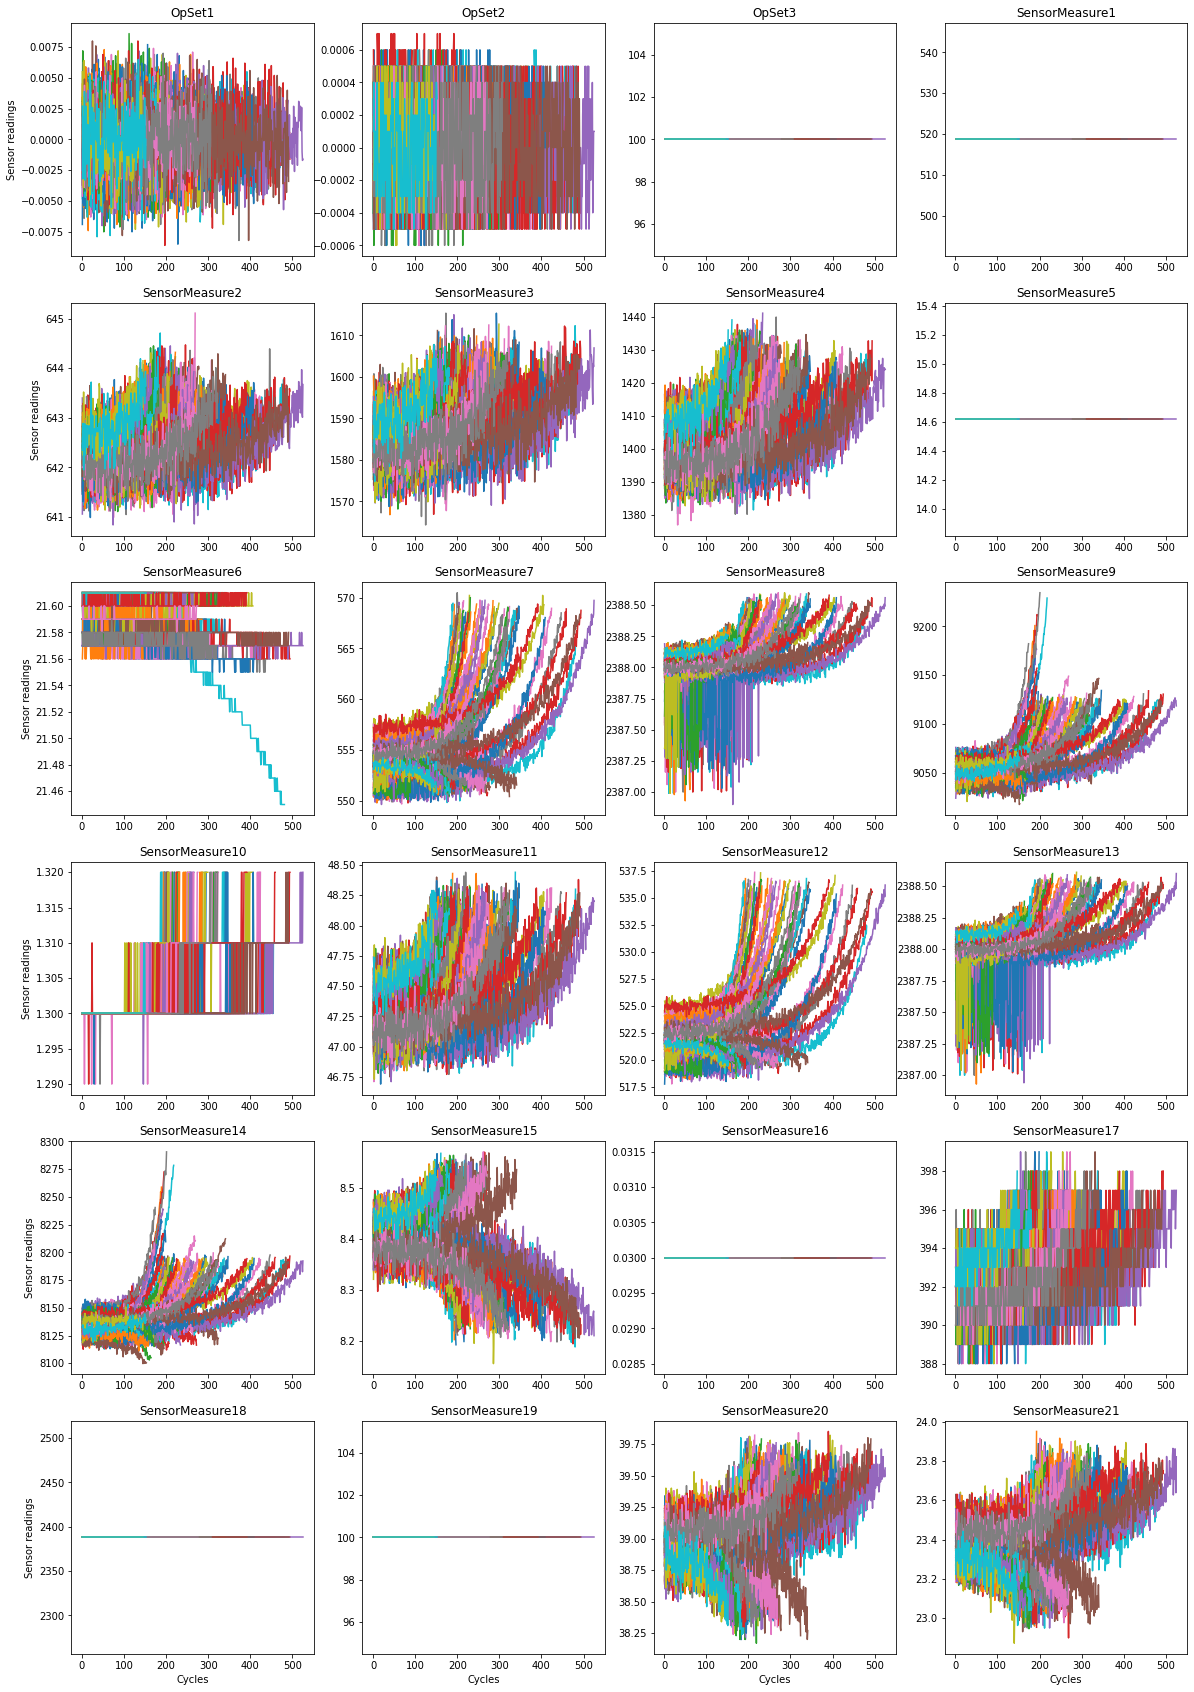

In [40]:
plot_by_engine(train_groupby, 6, sensor_names, 'fd003-sensors_unprocessed.jpg')

From the graph, we can see which sensors will have a greater impact on the performance of the regressor, and which are irrelevant for this task. I decided to take Sensors: 1, 5, 6, 10, 16, 18, 19

### Taking away all non-important sensors

In [41]:
sensors_used = []
sensors_used.append('ID')
sensors_used.append('Cycle')
for i in range(1, 22):
    # if i not in [1, 5, 6, 10, 16, 18, 19]:
    sensors_used.append("SensorMeasure" + str(i))

In [42]:
train_data_df = train_data_df[sensors_used]
train_grouppby = train_data_df.groupby(['ID'], sort=False)
test_groupby = test_data_df.groupby(['ID'], sort=False)

In [43]:
train_data_df

ID  Cycle  SensorMeasure1  SensorMeasure2  SensorMeasure3  \
0        1      1          518.67          642.36         1583.23   
1        1      2          518.67          642.50         1584.69   
2        1      3          518.67          642.18         1582.35   
3        1      4          518.67          642.92         1585.61   
4        1      5          518.67          641.68         1588.63   
...    ...    ...             ...             ...             ...   
24715  100    148          518.67          643.78         1596.01   
24716  100    149          518.67          643.29         1596.38   
24717  100    150          518.67          643.84         1604.53   
24718  100    151          518.67          643.94         1597.56   
24719  100    152          518.67          643.64         1599.04   

       SensorMeasure4  SensorMeasure5  SensorMeasure6  SensorMeasure7  \
0             1396.84           14.62           21.61          553.97   
1             1396.89           14.62           21.61          554.55   
2             1405.61           14.62           21.61          554.43   
3             1392.27           14.62           21.61          555.21   
4             1397.65           14.62           21.61          554.74   
...               ...             ...             ...             ...   
24715         1424.11           14.62           21.61          551.86   
24716         1429.14           14.62           21.61          551.86   
24717         1431.41           14.62           21.61          551.30   
24718         1426.57           14.62           21.61          550.69   
24719         1436.06           14.62           21.61          550.96   

       SensorMeasure8  ...  SensorMeasure12  SensorMeasure13  SensorMeasure14  \
0             2387.96  ...           522.31          2388.01          8145.32   
1             2388.00  ...           522.42          2388.03          8152.85   
2             2388.03  ...           522.03          2388.00          8150.17   
3             2388.00  ...           522.49          2388.08          8146.56   
4             2388.04  ...           522.58          2388.03          8147.80   
...               ...  ...              ...              ...              ...   
24715         2388.25  ...           519.66          2388.30          8138.08   
24716         2388.23  ...           519.91          2388.28          8144.36   
24717         2388.25  ...           519.44          2388.24          8135.95   
24718         2388.26  ...           520.01          2388.26          8141.24   
24719         2388.26  ...           519.48          2388.24          8136.98   

       SensorMeasure15  SensorMeasure16  SensorMeasure17  SensorMeasure18  \
0               8.4246             0.03              391             2388   
1               8.4403             0.03              392             2388   
2               8.3901             0.03              391             2388   
3               8.3878             0.03              392             2388   
4               8.3869             0.03              392             2388   
...                ...              ...              ...              ...   
24715           8.5036             0.03              394             2388   
24716           8.5174             0.03              395             2388   
24717           8.5223             0.03              396             2388   
24718           8.5148             0.03              395             2388   
24719           8.5150             0.03              396             2388   

       SensorMeasure19  SensorMeasure20  SensorMeasure21  
0                100.0            39.11          23.3537  
1                100.0            38.99          23.4491  
2                100.0            38.85          23.3669  
3                100.0            38.96          23.2951  
4                100.0            39.14          23.4583  
...                ...              ...           

### Principal Component Analysis

In [44]:
train_data_df.shape
ms_used = sensors_used[2:]

In [45]:
sc = MinMaxScaler()
scaled_values = sc.fit_transform(train_data_df.values[:, 2:])

pca = PCA(n_components = 0.99)
pca_values = pca.fit_transform(scaled_values)

Number of components: 12


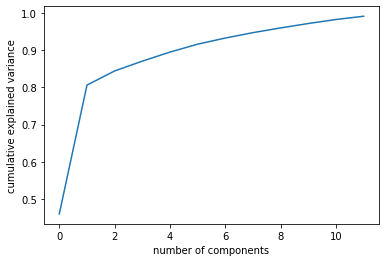

In [46]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
print("Number of components: " + str(pca.n_components_))

In [47]:
pd.DataFrame(pca.components_, columns = ms_used)

SensorMeasure1  SensorMeasure2  SensorMeasure3  SensorMeasure4  \
0             -0.0        0.153563        0.217182        0.226481   
1              0.0        0.271349        0.248257        0.357772   
2             -0.0        0.098147        0.011053        0.169116   
3             -0.0       -0.150597        0.004954       -0.168659   
4              0.0        0.146696        0.382689        0.144028   
5              0.0        0.263784       -0.793700        0.237473   
6              0.0        0.852390       -0.025807       -0.342125   
7              0.0        0.200957        0.325086       -0.221135   
8              0.0       -0.104632       -0.070941       -0.708718   
9             -0.0        0.020143        0.003947        0.020942   
10            -0.0        0.015790        0.051690        0.110353   
11            -0.0        0.014533        0.022449        0.035106   

    SensorMeasure5  SensorMeasure6  SensorMeasure7  SensorMeasure8  \
0     2.775558e-17       -0.009042        0.406631        0.203788   
1     2.775558e-17        0.193671       -0.212975        0.086273   
2     1.110223e-16       -0.860312       -0.066107       -0.231543   
3     1.387779e-17        0.010113       -0.054579       -0.107502   
4    -2.081668e-17        0.121765        0.026973       -0.087741   
5     3.261280e-16        0.220697        0.053557       -0.192128   
6    -1.249001e-16       -0.117825       -0.015643        0.145017   
7    -2.775558e-17        0.250482       -0.008995       -0.497407   
8    -1.387779e-16       -0.009982        0.021807        0.063722   
9    -0.000000e+00        0.071689        0.045635        0.056412   
10   -1.387779e-16       -0.000720        0.004007       -0.161417   
11    1.387779e-16        0.249113        0.133066       -0.141719   

    SensorMeasure9  SensorMeasure10  ...  SensorMeasure12  SensorMeasure13  \
0         0.189365         0.270429  ...         0.414079         0.206068   
1         0.052510        -0.071346  ...        -0.204694         0.086932   
2         0.037219         0.150801  ...        -0.060870        -0.234555   
3         0.609700        -0.118938  ...        -0.052618        -0.108821   
4         0.220821         0.062631  ...         0.028532        -0.091586   
5         0.123021         0.165646  ...         0.055771        -0.193278   
6         0.018086        -0.189199  ...        -0.018839         0.145148   
7        -0.114982         0.314558  ...        -0.005182        -0.504005   
8         0.051133         0.100342  ...         0.019273         0.061315   
9        -0.035580         0.438366  ...         0.046308         0.055507   
10       -0.013609        -0.636593  ...         0.011250        -0.164555   
11       -0.047735        -0.232631  ...         0.130225        -0.145827   

    SensorMeasure14  SensorMeasure15  SensorMeasure16  SensorMeasure17  \
0          0.170932        -0.238502     3.774823e-32         0.272513   
1          0.017255         0.343007     1.417484e-31         0.319857   
2          0.030400        -0.149924    -0.000000e+00         0.017776   
3          0.620973         0.048989    -2.710505e-20         0.268474   
4          0.219200         0.047490     5.421011e-20        -0.816314   
5          0.113644         0.067195    -2.168404e-19        -0.101673   
6          0.019630        -0.060206     2.081668e-17        -0.005188   
7         -0.108008         0.077074    -5.551115e-17         0.254394   
8          0.045296        -0.008233     3.330669e-16        -0.077946   
9         -0.034134        -0.059214     1.110223e-16         0.018360   
10        -0.015518        -0.073909    -1.665335e-16         0.045884   
11        -0.041593        -0.721805     3.469447e-17         0.031147   

    SensorMeasure18  SensorMeasure19  SensorMeasure20  SensorMeasure21  
0              -0.0    -6.842278e-49         0.232178         0.218397  
1               0.0     0.000000e+00        -0.345517     

In [48]:
n_pcs = pca.n_components_
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = ms_used
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

print(most_important_names)

['SensorMeasure12', 'SensorMeasure11', 'SensorMeasure6', 'SensorMeasure14', 'SensorMeasure17', 'SensorMeasure3', 'SensorMeasure2', 'SensorMeasure13', 'SensorMeasure4', 'SensorMeasure20', 'SensorMeasure21', 'SensorMeasure15']


In [49]:
fig = px.scatter_3d(pca_values, x=0, y=1, z=2, color=train_data_df['ID'])
fig.show()
fig.write_html("fd003-PCA-3d_plot.html")

Sensors 2, 3, 4, 6, 7, 11, 12, 13, 14, 15, 17, 21 contribute the most to each of the components of the PCA, so they could have value towards the performance of the algorithm.

### Feature Selection using Mann-Kendall method

<function matplotlib.pyplot.show(close=None, block=None)>

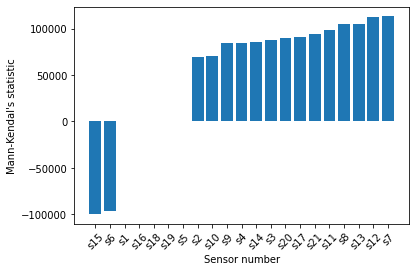

In [50]:
# PyMannKendall test: Code by Zhan Liang, Chan - https://github.com/cchanzl/survival-analysis-nasa/blob/main/nasa_eda.ipynb
avg_cycle = []
for i in range(1, 101):
    df_engine = train_data_df[train_data_df['ID'] == i]
    max_cycle = df_engine.loc[df_engine['Cycle'].idxmax()]
    avg_cycle.append(max_cycle["Cycle"].astype(int))

no_columns = 21
up_sensor_values = np.empty([max(avg_cycle), no_columns]) # 26 sensors with a max cycle of 362
lo_sensor_values = np.empty([max(avg_cycle), no_columns]) # 26 sensors with a max cycle of 362
for col in range(0, no_columns):
    sensor = 'SensorMeasure'
    sensor = sensor + str(col+1)
    for row in range(0, max(avg_cycle)):
        df_train_sens = train_data_df[train_data_df['Cycle'] == row+1]
        
        # find max and min value of a sensor for each cycle
        max_value = df_train_sens.loc[df_train_sens[sensor].idxmax()]
        min_value = df_train_sens.loc[df_train_sens[sensor].idxmin()]
        
        # store max and min value
        up_sensor_values[row, col] = max_value[sensor]
        lo_sensor_values[row, col] = min_value[sensor]
mean_trend = (up_sensor_values + lo_sensor_values)/2

mono = []
def MannKendall(sensor_number, mean_trend, p_value=False):
    sensor_number -= 1
    trend, h, p, z, Tau, s, var_s, slope, intercept = mk.original_test([row[sensor_number] for row in mean_trend], alpha=0.05)
    if p_value:
        print("{:e}".format(var_s))
    return s

# make x label for graphing
sensor_header = []
for i in range(0, 21):
    name = "s"
    name = name + str(i+1)
    sensor_header.append(name)

# retrieve y axis reading
for i in range(1, no_columns+1):
    mono.append(MannKendall(i, mean_trend))

y,x = zip(*sorted(zip(mono,sensor_header)))
plt.bar(x, y)
plt.xlabel("Sensor number")
plt.ylabel("Mann-Kendal's statistic")
plt.xticks(rotation=45)
plt.show

According to the PyMannKendall test, the most useful sensors would be 2, 3, 4, 7, 8, 11, 12, 13, 15, 17, 20, 21. I will follow Zhan's decision on feature selection.

In [51]:
# train_data_df.to_csv('./fd003-raw_train.csv', sep=' ', columns=train_data_df.columns, index=False)
# test_data_df[train_data_df.columns].to_csv('./fd003-raw_test.csv', sep=' ', columns=train_data_df.columns, index=False)

In [52]:
train_labels_df.to_csv('./fd003-training_labels.csv', sep=' ', columns=['RUL'], index=False)
test_labels_df.to_csv('./fd003-testing_labels.csv', sep=' ', columns=['RUL'], index=False)
train_labels_at_break_df.to_csv('./fd003-testing_labels_at_break.csv', sep=' ', columns=['RUL'], index=False)

In [53]:
sensors_used = []
sensors_used.append('ID')
sensors_used.append('Cycle')
for i in range(1, 22):
    # if i not in [1, 5, 16, 18, 19]:
    if i not in [1, 5, 6, 10, 16, 18, 19]:
        sensors_used.append("SensorMeasure" + str(i))
ms_used = sensors_used[2:]

### Scaling and Normalising Data

In [54]:
train_data_df = train_data_df[sensors_used]
test_data_df = test_data_df[sensors_used]

In [55]:
train_data_df

ID  Cycle  SensorMeasure2  SensorMeasure3  SensorMeasure4  \
0        1      1          642.36         1583.23         1396.84   
1        1      2          642.50         1584.69         1396.89   
2        1      3          642.18         1582.35         1405.61   
3        1      4          642.92         1585.61         1392.27   
4        1      5          641.68         1588.63         1397.65   
...    ...    ...             ...             ...             ...   
24715  100    148          643.78         1596.01         1424.11   
24716  100    149          643.29         1596.38         1429.14   
24717  100    150          643.84         1604.53         1431.41   
24718  100    151          643.94         1597.56         1426.57   
24719  100    152          643.64         1599.04         1436.06   

       SensorMeasure7  SensorMeasure8  SensorMeasure9  SensorMeasure11  \
0              553.97         2387.96         9062.17            47.30   
1              554.55         2388.00         9061.78            47.23   
2              554.43         2388.03         9070.23            47.22   
3              555.21         2388.00         9064.57            47.24   
4              554.74         2388.04         9076.14            47.15   
...               ...             ...             ...              ...   
24715          551.86         2388.25         9070.82            48.27   
24716          551.86         2388.23         9064.60            48.13   
24717          551.30         2388.25         9063.45            48.18   
24718          550.69         2388.26         9062.22            48.05   
24719          550.96         2388.26         9066.52            48.12   

       SensorMeasure12  SensorMeasure13  SensorMeasure14  SensorMeasure15  \
0               522.31          2388.01          8145.32           8.4246   
1               522.42          2388.03          8152.85           8.4403   
2               522.03          2388.00          8150.17           8.3901   
3               522.49          2388.08          8146.56           8.3878   
4               522.58          2388.03          8147.80           8.3869   
...                ...              ...              ...              ...   
24715           519.66          2388.30          8138.08           8.5036   
24716           519.91          2388.28          8144.36           8.5174   
24717           519.44          2388.24          8135.95           8.5223   
24718           520.01          2388.26          8141.24           8.5148   
24719           519.48          2388.24          8136.98           8.5150   

       SensorMeasure17  SensorMeasure20  SensorMeasure21  
0                  391            39.11          23.3537  
1                  392            38.99          23.4491  
2                  391            38.85          23.3669  
3                  392            38.96          23.2951  
4                  392            39.14          23.4583  
...                ...              ...              ...  
24715              394            38.44          22.9631  
24716              395            38.50          22.9746  
24717              396            38.39          23.0682  
24718              395            38.31          23.0753  
24719              396            38.56          23.0847  

[24720 rows x 16 columns]

In [56]:
train_data_df.to_csv('./fd003-raw_train.csv', sep=' ', columns=train_data_df.columns, index=False)
test_data_df.to_csv('./fd003-raw_test.csv', sep=' ', columns=train_data_df.columns, index=False)

In [57]:
sc = MinMaxScaler()
for sensor in ms_used:
    train_data_df.loc[:,sensor] = sc.fit_transform(train_data_df[sensor].values.reshape(-1, 1))
    test_data_df.loc[:,sensor] = sc.fit_transform(test_data_df[sensor].values.reshape(-1, 1))

/opt/homebrew/lib/python3.9/site-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/homebrew/lib/python3.9/site-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/homebrew/lib/python3.9/site-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [58]:
train_data_df

ID  Cycle  SensorMeasure2  SensorMeasure3  SensorMeasure4  \
0        1      1        0.355972        0.370523        0.308580   
1        1      2        0.388759        0.399100        0.309360   
2        1      3        0.313817        0.353298        0.445398   
3        1      4        0.487119        0.417107        0.237285   
4        1      5        0.196721        0.476218        0.321217   
...    ...    ...             ...             ...             ...   
24715  100    148        0.688525        0.620669        0.734009   
24716  100    149        0.573770        0.627912        0.812480   
24717  100    150        0.702576        0.787434        0.847894   
24718  100    151        0.725995        0.651008        0.772387   
24719  100    152        0.655738        0.679977        0.920437   

       SensorMeasure7  SensorMeasure8  SensorMeasure9  SensorMeasure11  \
0            0.208812        0.623529        0.204233         0.348571   
1            0.236590        0.647059        0.202431         0.308571   
2            0.230843        0.664706        0.241484         0.302857   
3            0.268199        0.647059        0.215326         0.314286   
4            0.245690        0.670588        0.268799         0.262857   
...               ...             ...             ...              ...   
24715        0.107759        0.794118        0.244211         0.902857   
24716        0.107759        0.782353        0.215464         0.822857   
24717        0.080939        0.794118        0.210149         0.851429   
24718        0.051724        0.800000        0.204465         0.777143   
24719        0.064655        0.800000        0.224338         0.817143   

       SensorMeasure12  SensorMeasure13  SensorMeasure14  SensorMeasure15  \
0             0.231279         0.642857         0.239116         0.647755   
1             0.236882         0.654762         0.278567         0.685659   
2             0.217015         0.636905         0.264526         0.564462   
3             0.240448         0.684524         0.245612         0.558909   
4             0.245033         0.654762         0.252109         0.556736   
...                ...              ...              ...              ...   
24715         0.096281         0.815476         0.201184         0.838484   
24716         0.109017         0.803571         0.234086         0.871801   
24717         0.085074         0.779762         0.190025         0.883631   
24718         0.114111         0.791667         0.217740         0.865524   
24719         0.087112         0.779762         0.195421         0.866007   

       SensorMeasure17  SensorMeasure20  SensorMeasure21  
0             0.272727         0.559524         0.446331  
1             0.363636         0.488095         0.534836  
2             0.272727         0.404762         0.458577  
3             0.363636         0.470238         0.391966  
4             0.363636         0.577381         0.543371  
...                ...              ...              ...  
24715         0.545455         0.160714         0.083960  
24716         0.636364         0.196429         0.094628  
24717         0.727273         0.130952         0.181464  
24718         0.636364         0.083333         0.188051  
24719         0.727273         0.232143         0.196772  

[24720 rows x 16 columns]

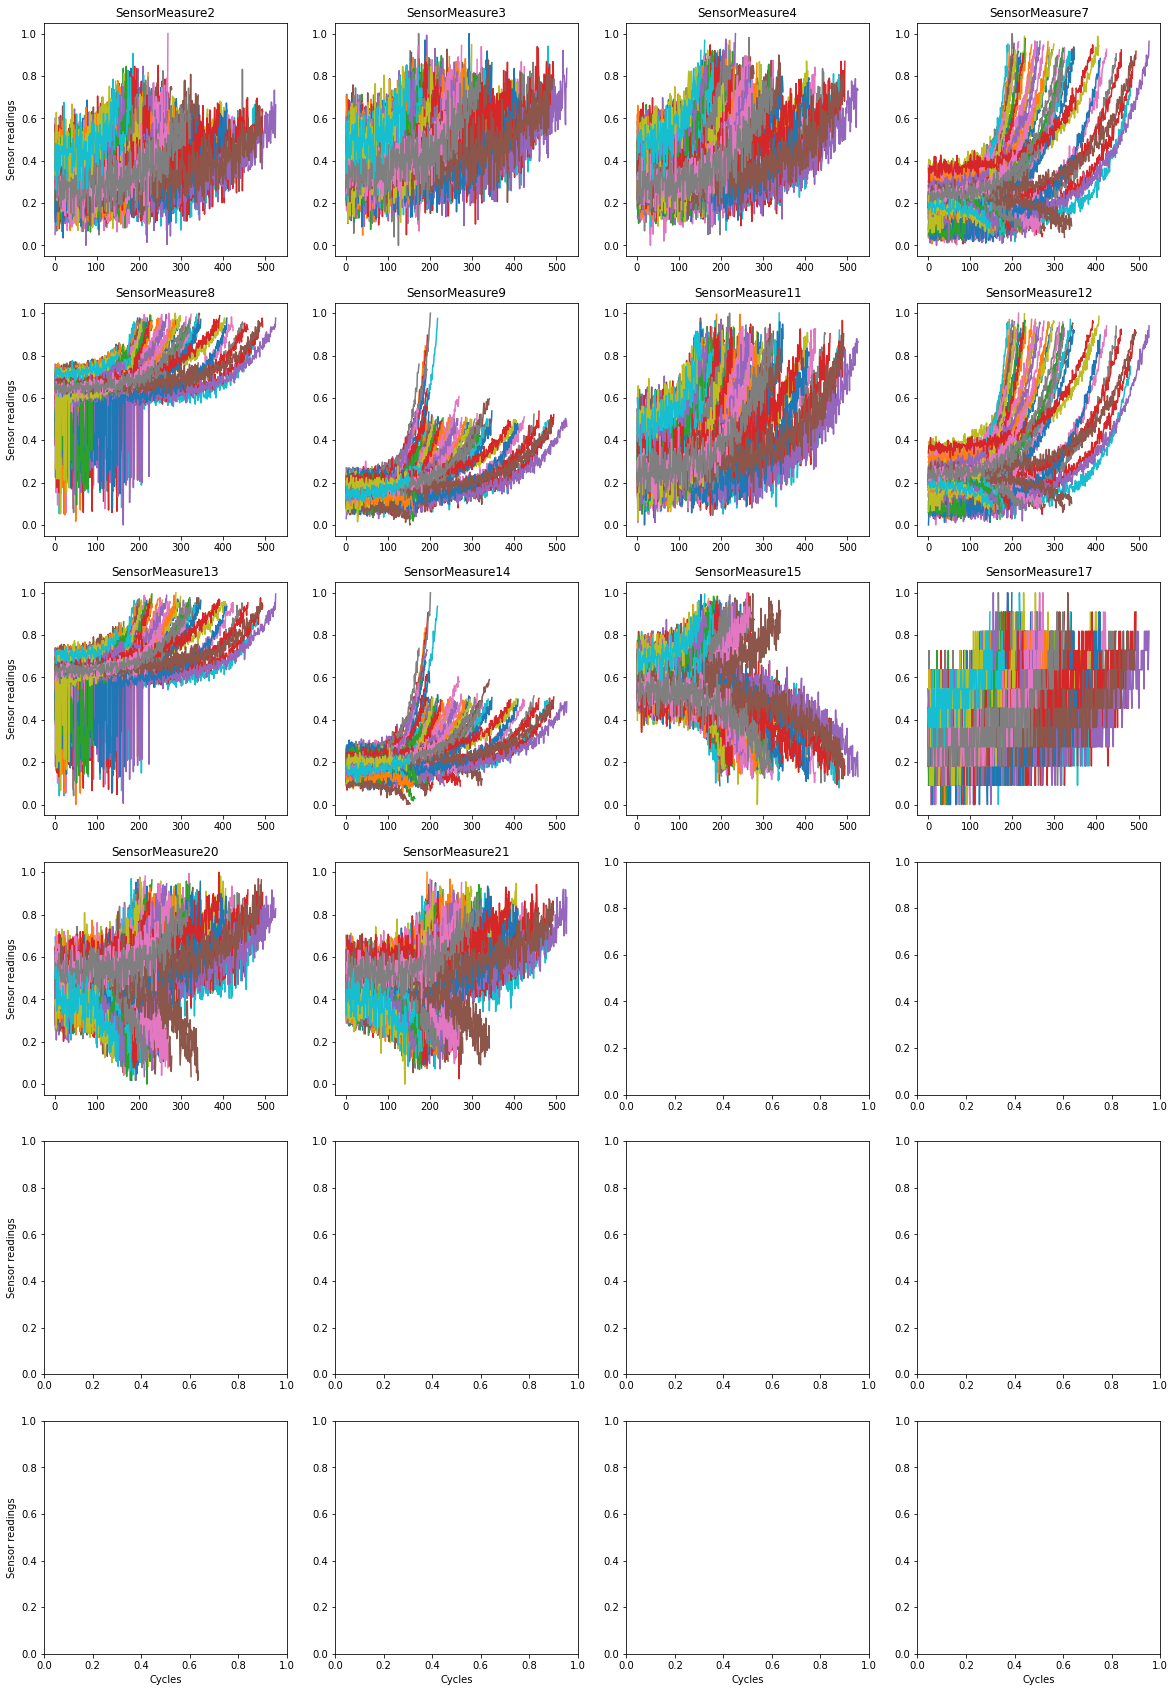

In [59]:
train_groupby = train_data_df.groupby(['ID'], sort=False)
plot_by_engine(train_groupby, 6, ms_used, 'fd003-sensors_scaled.jpg')

In [60]:
train_data_df.to_csv('./fd003-scaled_train.csv', sep=' ', columns=train_data_df.columns, index=False)
test_data_df.to_csv('./fd003-scaled_test.csv', sep=' ', columns=train_data_df.columns, index=False)

### Smoothing curves

In [61]:
train_groupby = train_groupby[['ID', 'Cycle'] + ms_used]
test_groupby = test_groupby[['ID', 'Cycle'] + ms_used]
train_groupby.get_group(1)

ID  Cycle  SensorMeasure2  SensorMeasure3  SensorMeasure4  \
0     1      1        0.355972        0.370523        0.308580   
1     1      2        0.388759        0.399100        0.309360   
2     1      3        0.313817        0.353298        0.445398   
3     1      4        0.487119        0.417107        0.237285   
4     1      5        0.196721        0.476218        0.321217   
..   ..    ...             ...             ...             ...   
254   1    255        0.599532        0.696222        0.793136   
255   1    256        0.702576        0.685261        0.728081   
256   1    257        0.627635        0.725582        0.751794   
257   1    258        0.660422        0.831865        0.846958   
258   1    259        0.725995        0.689763        0.893448   

     SensorMeasure7  SensorMeasure8  SensorMeasure9  SensorMeasure11  \
0          0.208812        0.623529        0.204233         0.348571   
1          0.236590        0.647059        0.202431         0.308571   
2          0.230843        0.664706        0.241484         0.302857   
3          0.268199        0.647059        0.215326         0.314286   
4          0.245690        0.670588        0.268799         0.262857   
..              ...             ...             ...              ...   
254        0.118774        0.811765        0.275547         0.885714   
255        0.098180        0.758824        0.243379         0.777143   
256        0.087644        0.811765        0.279059         0.840000   
257        0.108238        0.811765        0.309239         0.811429   
258        0.095307        0.794118        0.269538         0.942857   

     SensorMeasure12  SensorMeasure13  SensorMeasure14  SensorMeasure15  \
0           0.231279         0.642857         0.239116         0.647755   
1           0.236882         0.654762         0.278567         0.685659   
2           0.217015         0.636905         0.264526         0.564462   
3           0.240448         0.684524         0.245612         0.558909   
4           0.245033         0.654762         0.252109         0.556736   
..               ...              ...              ...              ...   
254         0.128884         0.767857         0.228428         0.873008   
255         0.107998         0.767857         0.269608         0.843795   
256         0.098828         0.791667         0.260282         0.904153   
257         0.099338         0.761905         0.268455         0.816997   
258         0.085074         0.773810         0.259182         0.905360   

     SensorMeasure17  SensorMeasure20  SensorMeasure21  
0           0.272727         0.559524         0.446331  
1           0.363636         0.488095         0.534836  
2           0.272727         0.404762         0.458577  
3           0.363636         0.470238         0.391966  
4           0.363636         0.577381         0.543371  
..               ...              ...              ...  
254         0.545455         0.130952         0.184618  
255         0.818182         0.172619         0.163466  
256         0.909091         0.113095         0.216347  
257         0.727273         0.190476         0.179237  
258         0.909091         0.107143         0.183783  

[259 rows x 16 columns]

In [62]:
smoothing_columns = ['ID', 'Cycle'] + ms_used
train_groupby_arr = []
for i in range(len(train_groupby)):
    df = train_groupby.get_group(i+1).copy()
    lowess_df = df.copy()
    for sensor in range(2, len(smoothing_columns)):
        sn = smoothing_columns[sensor]
        lowess_df[sn] = pd.DataFrame(lowess(df[sn], np.arange(len(df[sn])), frac=0.25)[:, 1], index=df.index, columns=[sn])
    train_groupby_arr.append(lowess_df)

tr_joined_lowess_df = train_groupby_arr[0]
for i in range(1, len(train_groupby_arr)):
    tr_joined_lowess_df = pd.concat([tr_joined_lowess_df, train_groupby_arr[i]])

test_groupby_arr = []
for i in range(len(test_groupby)):
    df = test_groupby.get_group(i+1).copy()
    lowess_df = df.copy()
    for sensor in range(2, len(smoothing_columns)):
        sn = smoothing_columns[sensor]
        lowess_df[sn] = pd.DataFrame(lowess(df[sn], np.arange(len(df[sn])), frac=0.25)[:, 1], index=df.index, columns=[sn])
    test_groupby_arr.append(lowess_df)

test_joined_lowess_df = test_groupby_arr[0]
for i in range(1, len(test_groupby_arr)):
    test_joined_lowess_df = pd.concat([test_joined_lowess_df, test_groupby_arr[i]])

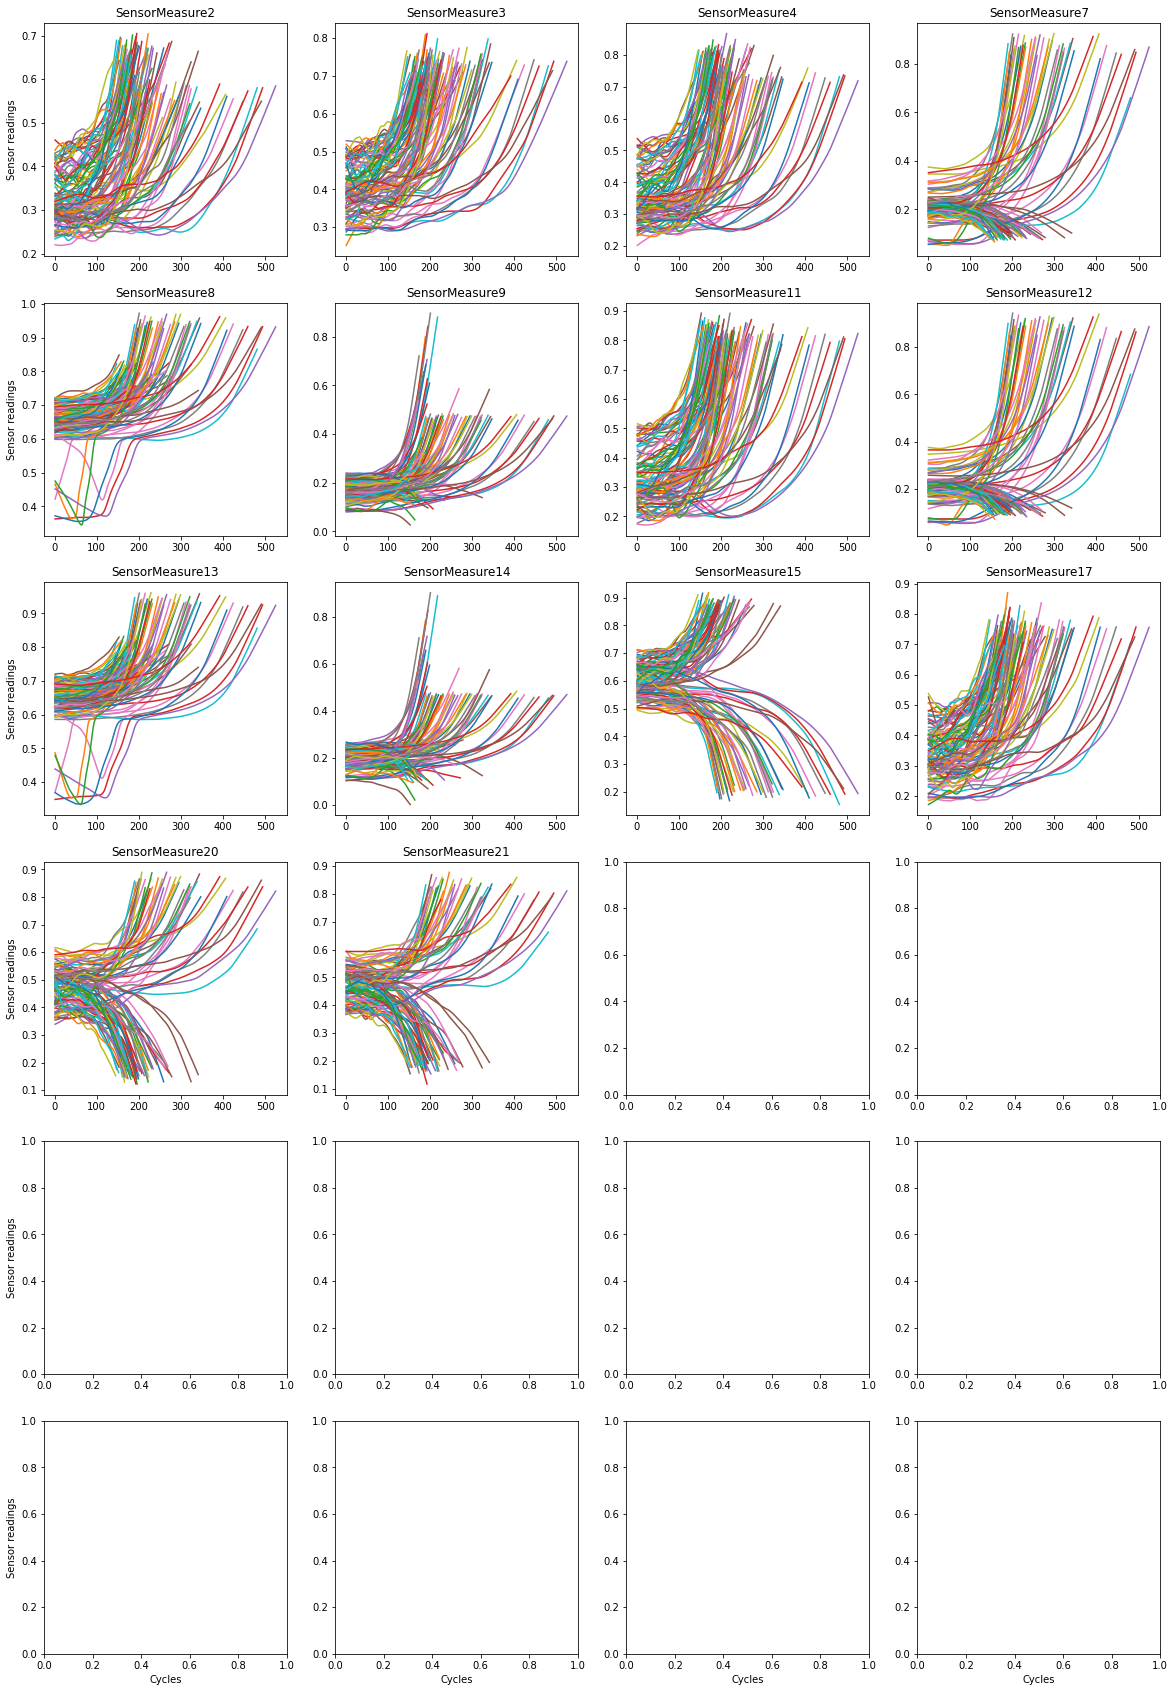

In [63]:
tr_joined_lowess_groupby = tr_joined_lowess_df.groupby(['ID'], sort = False)
plot_by_engine(tr_joined_lowess_groupby, 6, ms_used, 'fd003-sensors_smoothed.jpg')

In [64]:
tr_joined_lowess_df.to_csv('./fd003-smoothed_train.csv', sep=' ', columns=tr_joined_lowess_df.columns, index=False)
test_joined_lowess_df.to_csv('./fd003-smoothed_test.csv', sep=' ', columns=test_joined_lowess_df.columns, index=False)